[![image](https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo.png)](https://www.visual-layer.com)

# Use fastdup to cluster heatmaps of user GPS movements

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/visual-layer/fastdup/blob/main/examples/heatmaps.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/fastdup/blob/main/examples/heatmaps.ipynb)

In this tutorial we learn how to cluster heatmaps, look at their labels and find anomalies in heatmaps. As an example heatmaps are generate by GPS coordinates of taxi data in NY. However there are multiple other use cases which produce heatmaps where fastdup can be used.


In [29]:
#Install those two packages
#pip install folium
%pip install selenium

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [30]:
import folium
from folium.plugins import HeatMap
import random

Download Kaggle New York's taxi fare prediction test.csv dataset from https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data

In [32]:
import pandas as pd
df = pd.read_csv('test.csv')

In [33]:
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [8]:
len(df)

9914

In [9]:
pwd=!pwd
pwd=pwd[0]
print(pwd)

/Users/dannybickson/Documents/image_captioning


## Generate similated data of two types: either real taxi GPS coordinates or random noise.

In [22]:
import folium
from folium.plugins import HeatMap
import random
from tqdm import tqdm
import numpy as np

# Generate some random GPS coordinates for people moving around
coordinates = df[[ 'pickup_longitude','pickup_latitude']].to_numpy()
drop_coordinates = df[[ 'dropoff_longitude','dropoff_latitude']].to_numpy()

# Define the range of the number of points to sample
min_n_points = 70
max_n_points = 100

# Define the number of times to repeat the process
n_repeats = 100
!rm -fr heatmaps
!mkdir -p heatmaps
labels = []
filenames = []

for i in tqdm(range(n_repeats)):
    
    # Choose a random number of points to sample
    n_points = random.randint(min_n_points, max_n_points)
    # Sample n_points from the coordinates
    
    
    if i % 2 == 0:
        sampled_coordinates = random.sample(list(coordinates), n_points)
        label = "pickup"
    else:
        sampled_coordinates = random.sample(list(drop_coordinates), n_points)
        label = "dropoff"
        
       
    if i % 10 == 0:
        sampled_coordinates = np.array(sampled_coordinates)  # Convert back to 2xn numpy matrix

        # Modify longitude values with Gaussian noise
        mean_lon = np.mean(sampled_coordinates[:, 1])  # Mean longitude value
        std_dev = 0.0 # Standard deviation of Gaussian noise
        gaussian_noise = np.random.normal(0, std_dev, len(sampled_coordinates))  # Generate Gaussian noise
        sampled_coordinates[:, 1] = mean_lon + gaussian_noise  # Modify longitude values
        sampled_coordinates = list(sampled_coordinates)
        label = "noise"

    # Create a unique filename for the map
    filename = f"heatmaps/map_{i}.png"
    
    # Create a folium map centered at the first coordinate in the sampled points
    m = folium.Map(location=sampled_coordinates[0], zoom_start=12)

    # Add a heatmap layer for the sampled GPS coordinates
    HeatMap(sampled_coordinates).add_to(m)

    # Save the folium map as an HTML file
    #m.save(filename)
    #m.screenshot(filename)
    
    m.save('map.html')
    labels.append(label)
    filenames.append(filename)

    # Use selenium and chromedriver to take a screenshot of the HTML file and save it as a PNG image
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options

    options = Options()
    options.add_argument('--headless')
    driver = webdriver.Chrome(options=options)
    driver.get('file://' + pwd + '/map.html')
    driver.save_screenshot(filename)
    driver.quit()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


## Now look a the generated heatmaps

In [42]:
files=!find heatmaps -name '*.png'

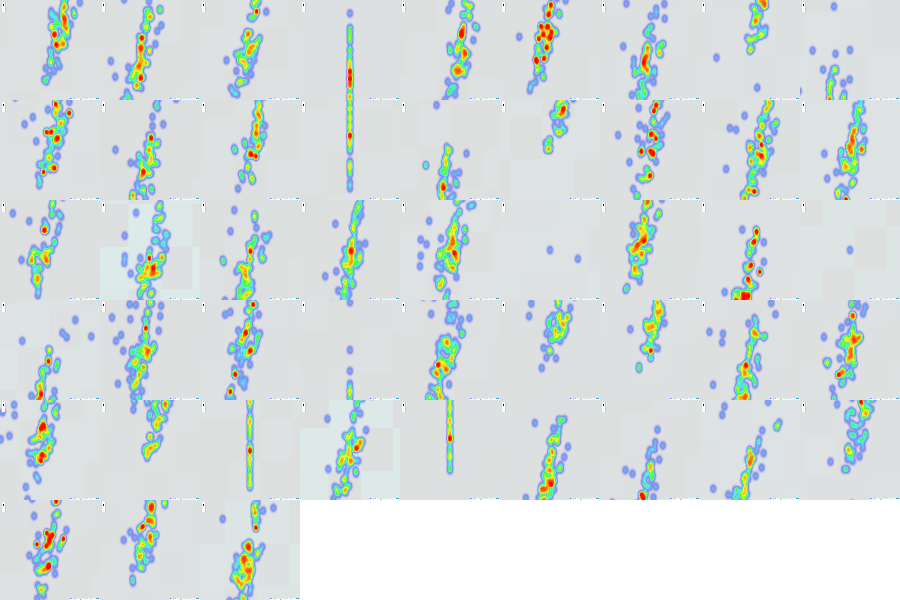

In [45]:
import fastdup
ret = fastdup.generate_sprite_image(files, 48, ".")[0]
from IPython.display import Image
Image(filename=ret)



# Build fastdup model to cluster heatmaps together

In [23]:
import fastdup
fd = fastdup.create(input_dir='heatmaps', work_dir='heat_out')

In [24]:
fd.run(overwrite=True, cc_threshold=0.94)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.

 ########################################################################################

Dataset Analysis Summary: 

    Dataset contains 100 images
    Valid images are 100.00% (100) of the data, invalid are 0.00% (0) of the data
    Similarity:  37.00% (37) belong to 9 similarity clusters (components).
    63.00% (63) images do not belong to any similarity cluster.
    Largest cluster has 32 (32.00%) images.
    For a detailed analysis, use `.connected_components()`
(similarity threshold used is 0.9, connected component threshold used is 0.94).

    Outliers: 7.00% (7) of images are possible outliers, and fall in the bottom 5.00% of similarity values.
    For a detailed list of outliers, use `.outliers()`.


## Plot heatmaps together

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.75it/s]


Finished OK. Components are stored as image files heat_out/galleries/components_[index].jpg
Stored components visual view in  heat_out/galleries/components.html
Execution time in seconds 2.7



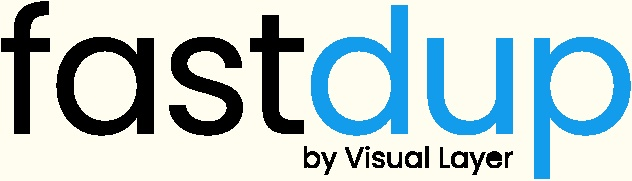
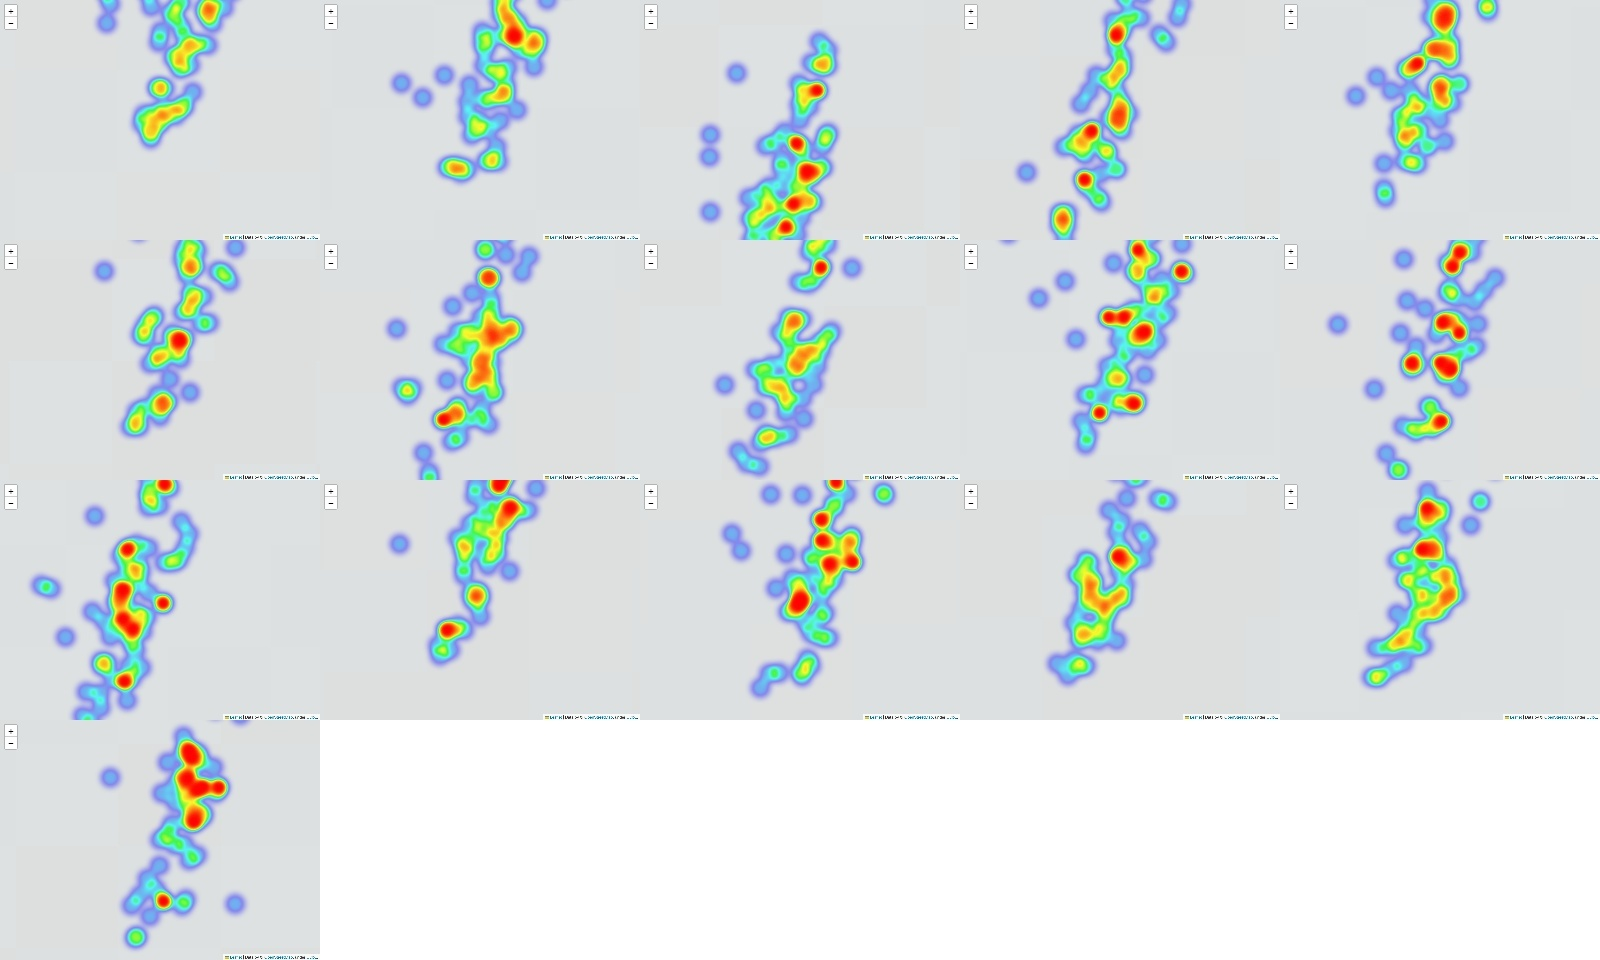
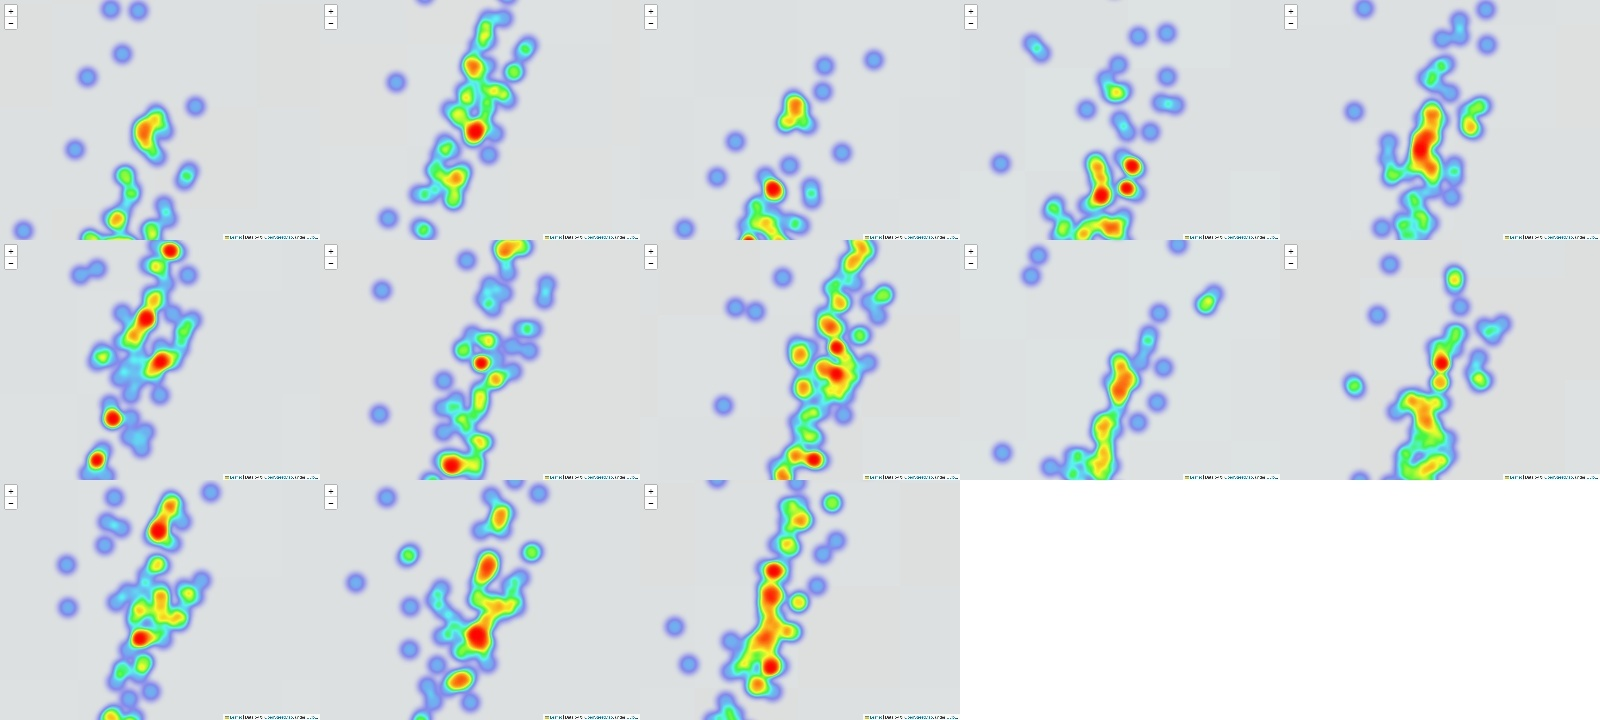
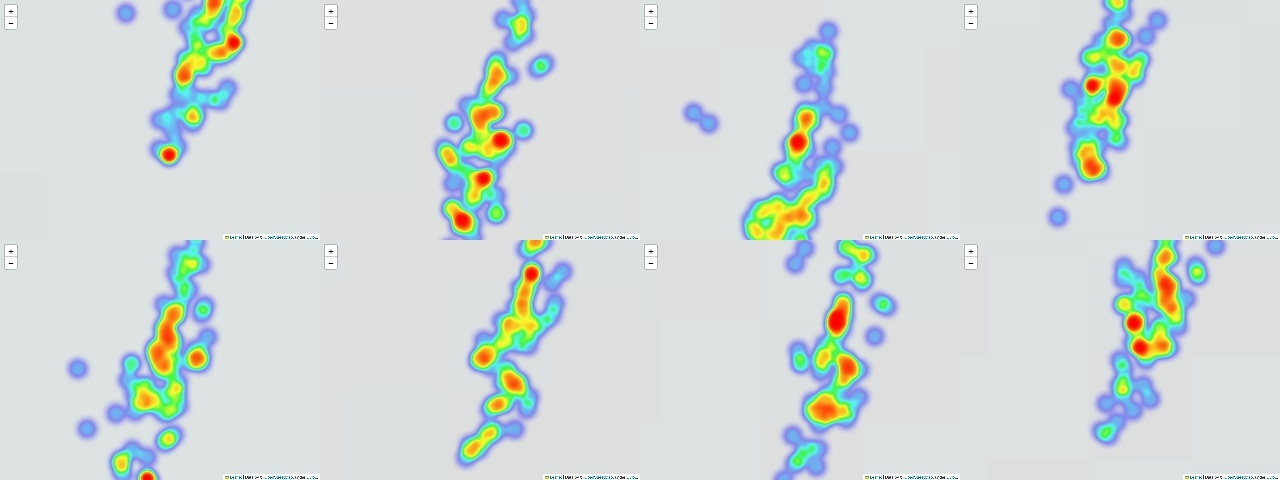
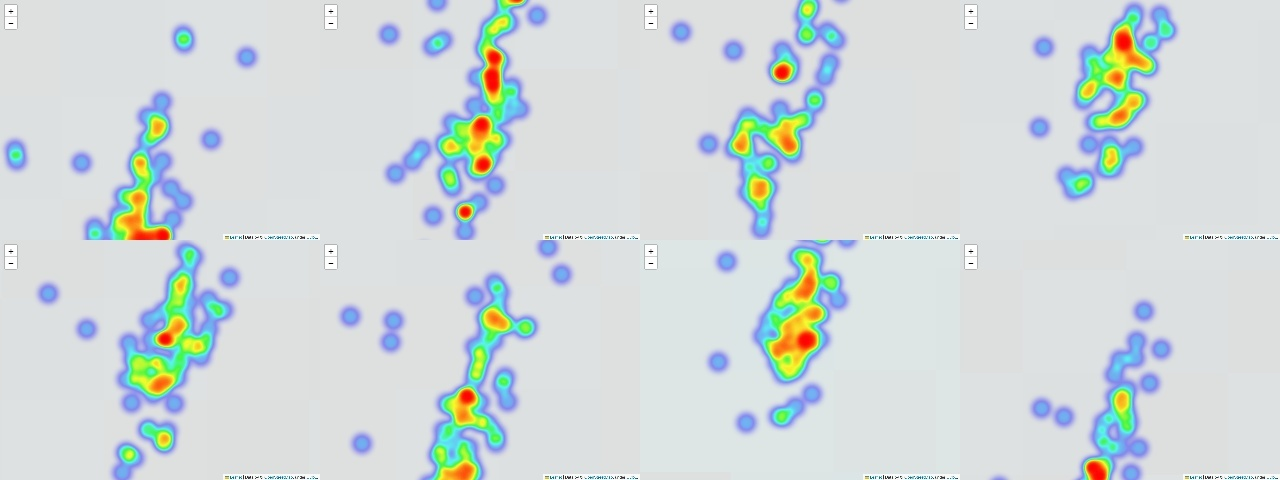
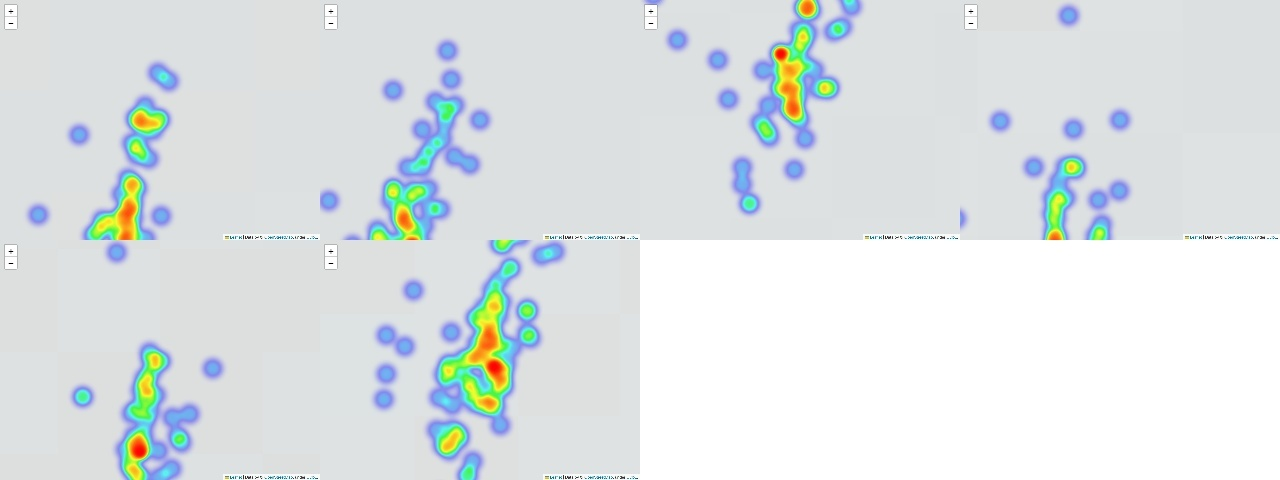
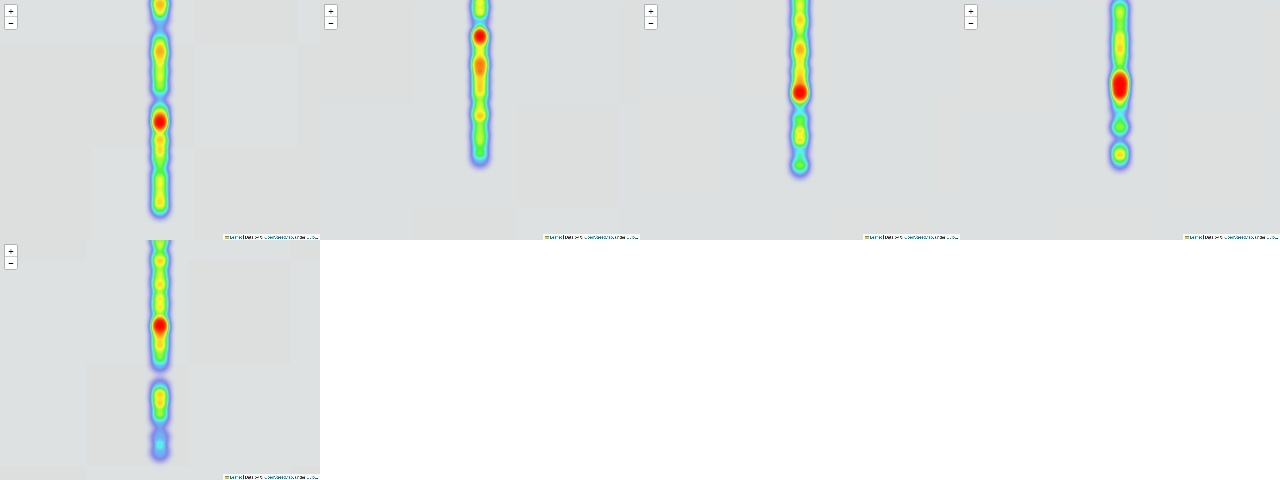
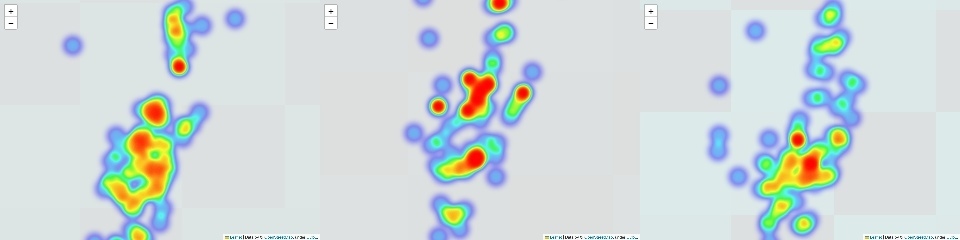
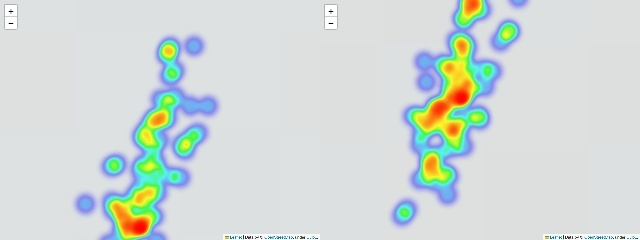
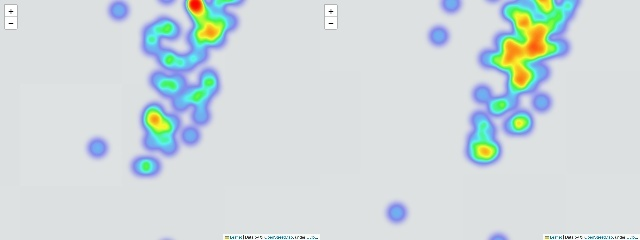
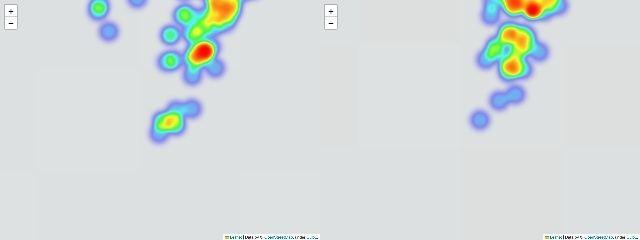
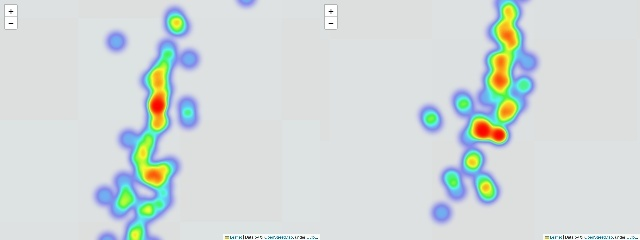
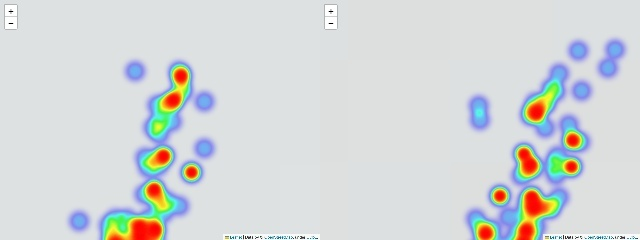
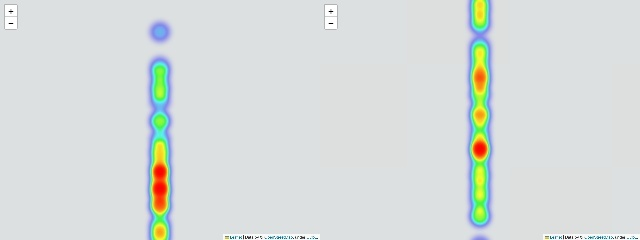
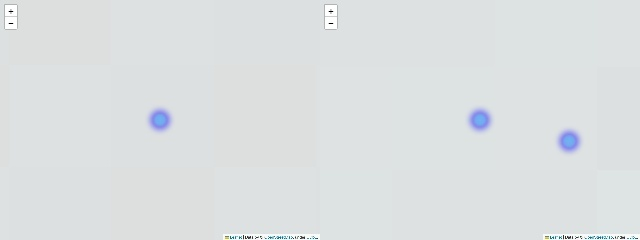
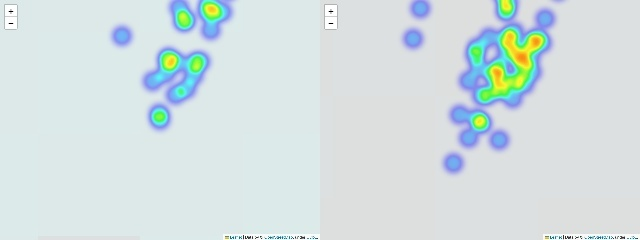

In [26]:
cdf = fastdup.find_top_components('heat_out')
labels_df = pd.DataFrame({'filename':filenames, 'label':labels})
label_dict = pd.Series(labels_df.label.values,index=labels_df.filename).to_dict()
cdf['label'] = cdf['files'].apply(lambda x: [label_dict[y] for y in x])
fd.vis.component_gallery(load_crops=False, sort_by='comp_size', external_df=cdf, label_col='label', ascending=True)


## Analyze outliers

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7336.36it/s]


Stored outliers visual view in  heat_out/galleries/outliers.html



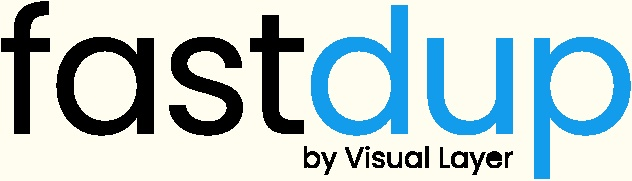
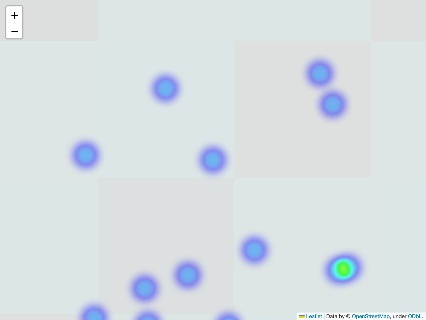
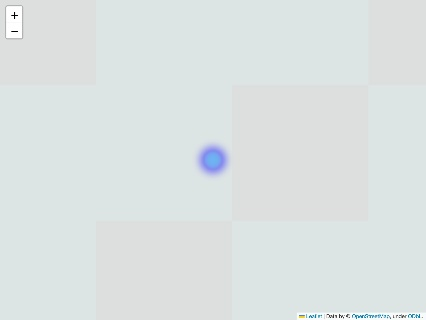
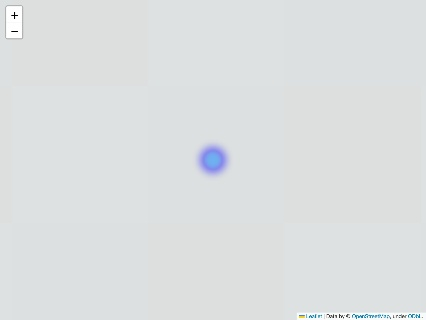
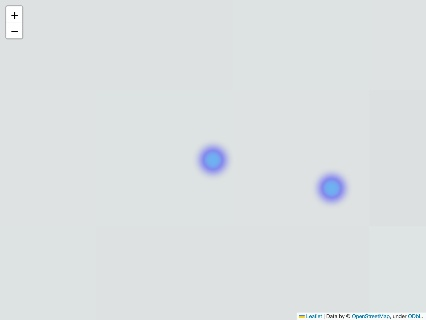
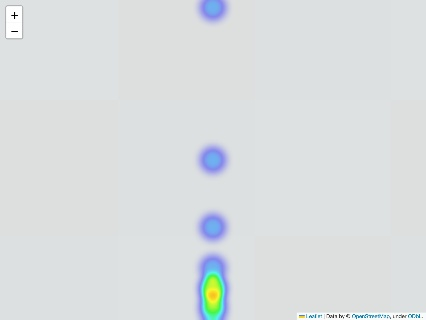
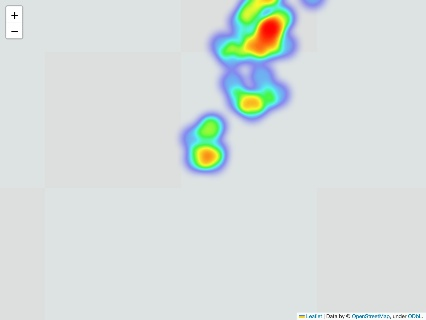
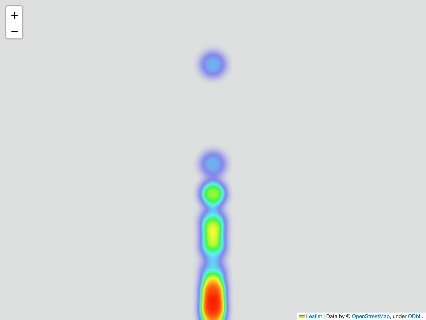

In [27]:
fd.vis.outliers_gallery()

## Wrap Up

Next, feel free to check out other tutorials -

+ ⚡ [**Quickstart**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/quick-dataset-analysis.ipynb): Learn how to install fastdup, load a dataset and analyze it for potential issues such as duplicates/near-duplicates, broken images, outliers, dark/bright/blurry images, and view visually similar image clusters. If you're new, start here!
+ 🧹 [**Clean Image Folder**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb): Learn how to analyze and clean a folder of images from potential issues and export a list of problematic files for further action. If you have an unorganized folder of images, this is a good place to start.
+ 🖼 [**Analyze Image Classification Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb): Learn how to load a labeled image classification dataset and analyze for potential issues. If you have labeled ImageNet-style folder structure, have a go!
+ 🎁 [**Analyze Object Detection Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb): Learn how to load bounding box annotations for object detection and analyze for potential issues. If you have a COCO-style labeled object detection dataset, give this example a try. 


## VL Profiler
If you prefer a no-code platform to inspect and visualize your dataset, [**try our free cloud product VL Profiler**](https://app.visual-layer.com) - VL Profiler is our first no-code commercial product that lets you visualize and inspect your dataset in your browser. 

[Sign up](https://app.visual-layer.com) now, it's free.

[![image](https://raw.githubusercontent.com/visual-layer/fastdup/main/gallery/vl_profiler_promo.svg)](https://app.visual-layer.com)

As usual, feedback is welcome! 

Questions? Drop by our [Slack channel](https://visualdatabase.slack.com/join/shared_invite/zt-19jaydbjn-lNDEDkgvSI1QwbTXSY6dlA#/shared-invite/email) or open an issue on [GitHub](https://github.com/visual-layer/fastdup/issues).